## Introduction
In this report we will have a closer at the Total Value Locked (TVL) of Sushiswap and Uniswap on Ethereum and compare it over time.

### Preparing the environment
1. Importing modules necessary for the processing and analysis of the data.

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import numpy as np
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
import requests

2. Importing Total Value Locked information about each one of the decentralized exchanges protocols. The data will be imported using TheGraph API endpoints and then it is turned into a Pandas Dataframe so we can use Python to analyze and plot the data.

First one is the daily TVL of Sushiswap:

In [125]:
# Sushi TheGraph
url = 'https://api.thegraph.com/subgraphs/name/zippoxer/sushiswap-subgraph-fork'
transport = AIOHTTPTransport(url=url)
client = Client(transport=transport)

query_SushiTVL = gql(
    '''{uniswapDayDatas (orderBy: date, orderDirection: desc, first: 90) 
  {
    date
    totalLiquidityUSD
  }
}'''
)
response_SushiTVL = await client.execute_async(query_SushiTVL)

df_SushiTVL = pd.json_normalize(response_SushiTVL['uniswapDayDatas'])\
    .rename(columns={'date':'timestamp','totalLiquidityUSD':'tvlUSD'})
df_SushiTVL['date'] = pd.to_datetime(df_SushiTVL.timestamp, unit='s')
df_SushiTVL['dex'] = 'Sushi'
df_SushiTVL.tvlUSD = df_SushiTVL.tvlUSD.apply(lambda x: float(x))

Uniswap currently has 2 live versions, Uniswap V2 and V3, and in this report we will aggregate the TVL of both.

In [126]:
# Uniswap V3 TheGraph
url = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'
transport = AIOHTTPTransport(url=url)
client = Client(transport=transport)

query_Uni3TVL = gql(
    '''{uniswapDayDatas (orderBy: date, orderDirection: desc, first: 90) 
  {
    date
    tvlUSD
  }
}'''
)
response_Uni3TVL = await client.execute_async(query_Uni3TVL)

df_Uni3TVL = pd.json_normalize(response_Uni3TVL['uniswapDayDatas']).rename(columns={'date':'timestamp'})
df_Uni3TVL['date'] = pd.to_datetime(df_Uni3TVL.timestamp, unit='s')
df_Uni3TVL.tvlUSD = df_Uni3TVL.tvlUSD.apply(lambda x: float(x))

In [127]:
# Uniswap V2 TheGraph
url = 'https://api.thegraph.com/subgraphs/name/ianlapham/uniswapv2'
transport = AIOHTTPTransport(url=url)
client = Client(transport=transport)

query_Uni2TVL = gql(
    '''{uniswapDayDatas (orderBy: date, orderDirection: desc, first: 90) 
  {
    date
    totalLiquidityUSD
  }
}'''
)
response_Uni2TVL = await client.execute_async(query_Uni2TVL)

df_Uni2TVL = pd.json_normalize(response_Uni2TVL['uniswapDayDatas'])\
  .rename(columns={'date':'timestamp','totalLiquidityUSD':'tvlUSD'})
df_Uni2TVL['date'] = pd.to_datetime(df_Uni2TVL.timestamp, unit='s')
df_Uni2TVL.tvlUSD = df_Uni2TVL.tvlUSD.apply(lambda x: float(x))

Once we have the data for both versions of the exchange, we can use Pandas to merge the two dataframes and then sum the daily TVL.

In [128]:
df_UniTVL = pd.concat([df_Uni2TVL,df_Uni3TVL]).reset_index().drop(columns=['index'])
df_UniTVL = df_UniTVL.groupby(['date']).tvlUSD.sum().reset_index()
df_UniTVL['dex'] = 'Uniswap'
df_UniTVL.head()

,date,tvlUSD,dex
0,2021-11-17,9.861038e+09,Uniswap
1,2021-11-18,9.258397e+09,Uniswap
2,2021-11-19,9.850929e+09,Uniswap
3,2021-11-20,1.008030e+10,Uniswap
4,2021-11-21,9.821427e+09,Uniswap


Before we can start plotting the data, we will create a common dataframe containing the labeled data for each exchange.

In [129]:
df_tvl = pd.concat([df_SushiTVL,df_UniTVL]).reset_index()
df_tvl.tvlUSD = df_tvl.tvlUSD.apply(lambda x: np.round(float(x),2))
df_tvl.head()

,index,timestamp,tvlUSD,date,dex
0,0,1.644797e+09,2.130854e+09,2022-02-14,Sushi
1,1,1.644710e+09,2.144697e+09,2022-02-13,Sushi
2,2,1.644624e+09,2.167220e+09,2022-02-12,Sushi
3,3,1.644538e+09,2.176018e+09,2022-02-11,Sushi
4,4,1.644451e+09,2.277868e+09,2022-02-10,Sushi


## DEX Total Value Locked Comparison

Sushiswap and Uniswap are long time competitors on the Ethereum blockchain. They bot run on a suite of smart contracts that enable users to swap assets in a decentralized permissionless mode. 

Because they both work as Automated Market Makers, one of the most important metrics affecting the bottom line and the user experiece (cost), is the TVL. 

In the following graph we can see how this metric has changed for each of them over the last 90 days (3 months).

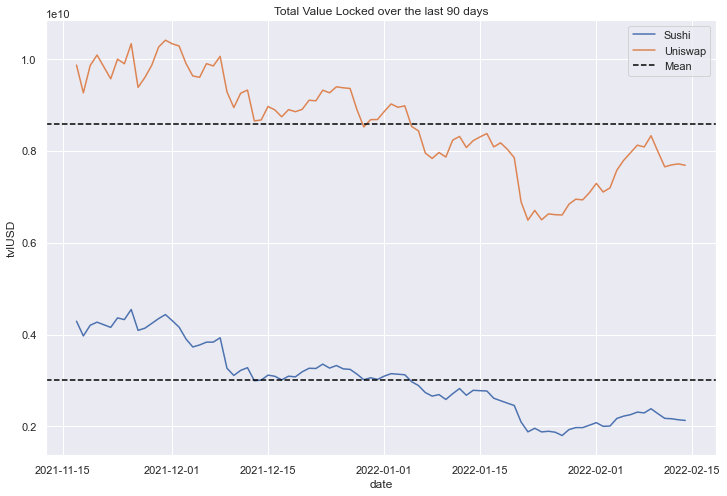

In [130]:
plt.figure(figsize=(12,8))
ax = plt.subplot()

sns.lineplot(data=df_tvl, x='date', y='tvlUSD', hue='dex')
plt.title('Total Value Locked over the last 90 days')
plt.axhline(np.mean(df_tvl[df_tvl.dex == 'Sushi'].tvlUSD), color='black', label='Mean', linestyle='--')
plt.axhline(np.mean(df_tvl[df_tvl.dex == 'Uniswap'].tvlUSD), color='black', linestyle='--')

plt.legend()
plt.show()

We can see that from the start of the period that there is a signifficant difference between the two, with Uniswap having 10.04B USD at the start of period across its two versions, whereas Sushiswap has a bit over 4.5B USD. This difference between the two is maintained throughout the last 90 days.

Despite this difference, we can see how the TVL of the two move almost in tandem. When one drops, almost every time the other does too. It is worth noting though that the Uniswap TVL has sharper movements, whereas that of Sushiswap is relatively more stable.

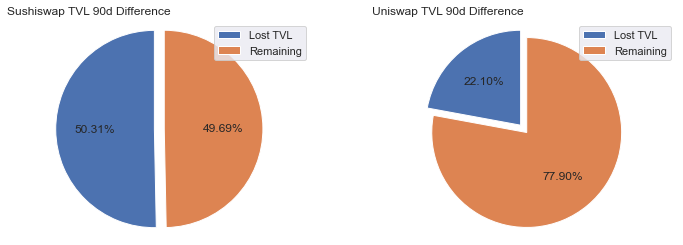

In [162]:
plt.figure(figsize=(12,4))

sushi = list(df_tvl[df_tvl['dex'] == 'Sushi'].sort_values(by='date', ascending=True).tvlUSD)
sushi_diff = sushi[0]-sushi[-1]
sushi_slices = [sushi_diff, sushi[-1]]

ax1 = plt.subplot(1,2,1)
plt.pie(sushi_slices, explode=[0.1,0], autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Sushiswap TVL 90d Difference', loc='left')
plt.legend(labels=['Lost TVL','Remaining'])

uni = list(df_tvl[df_tvl['dex'] == 'Uniswap'].sort_values(by='date', ascending=True).tvlUSD)
uni_diff = uni[0]-uni[-1]
uni_slices = [uni_diff, uni[-1]]

ax2 = plt.subplot(1,2,2)
plt.pie(uni_slices, explode=[0.1,0], autopct='%0.2f%%', startangle=90)
plt.axis('equal')
plt.title('Uniswap TVL 90d Difference', loc='left')
plt.legend(labels=['Lost TVL','Remaining'])
plt.show()

Another point of similarity is that compared to the start of the period they both had a drop of around 2B USD. This value however has a different signifficance for the two.

We can observe in the two pie-charts above that while for Uniswap the drop represented a 22% drop from the start of the period, for Sushiswap it means it only has 50% of the TVL at the start of the 90 day period. 